SMAP - Satelite Salinity Data

https://podaac.jpl.nasa.gov/dataset/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5

Short Name:
SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5

Collection Concept ID:
C2208425700-POCLOUD

In [1]:
import s3fs
import os
import os.path
import json
import warnings
import requests
import numpy as np
import pandas as pd
import xarray as xr
from io import StringIO

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker, rc, cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

# import geoviews as gv
# import hvplot.xarray
# import holoviews as hv
# gv.extension('bokeh', 'matplotlib')

warnings.filterwarnings("ignore")

# %matplotlib inline
# %matplotlib qt5
%matplotlib widget

## Set some parameters (start/end time)

In [2]:
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 400

savefig = False # set to true to save plots as file
!mkdir ../plots

__figdir__ = '../plots/'
savefig_args = {'bbox_inches':'tight', 'pad_inches':0.2}
plotfiletype='png'

mkdir: cannot create directory ‘../plots’: File exists


## PO DAAC Catalog exploration using the CMR API

- The search is restricted to colections that have data over a given time window

In [3]:
provider = 'POCLOUD'
url = 'https://cmr.earthdata.nasa.gov/search/collections.umm_json'
response = requests.get(url,
                        params={
                            'cloud_hosted': 'True',
                            'has_granules': 'True',
                            'provider': provider,
                            'page_size': 500,
                            'temporal': ['2021-10-01T10:00:00Z','2021-11-01T00:00:00Z'] 
                        },
                        headers={
                            'Accept': 'application/json'
                        }
                       )
response.headers['cmr-hits']

'241'

### Loop through each response in the catalog and print the respective concept ID

These are the data sets that cover the time period of interest

In [4]:
#  This will show short names and concept ids for all PO.DAAC data sets at this time
if False:
    for r in response.json()['items']:
        print('{} ==> '.format(r['meta']['s3-links'][0].split('/')[1]), r['meta']['concept-id'])

### Loading credentials for direct access

In [5]:
def begin_s3_direct_access(url: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

type(fs)

s3fs.core.S3FileSystem

In [6]:
# Center location
#site = 'S-MODE'
site = 'S-MODE IOP1'
#site = 'SPURS-1'

if site == 'S-MODE':
    lon0 = -123.5
    lat0 = 37.5 
    dlon = 2.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'S-MODE IOP1':
    lon0 = -124.5
    lat0 = 37
    dlon = 2.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'SPURS-2':
    lon0 = -125
    lat0 = 10
    dlon = 1.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'SPURS-1':
    lon0 = -38
    lat0 = 25
    dlon = 1.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat

# Define the max/min lon
lon_min = lon0 - dlon
lon_max = lon0 + dlon
lat_min = lat0 - dlat
lat_max = lat0 + dlat


In [7]:
if site == 'S-MODE':
    start_time = '2021-10-20T00:00:00Z'
    end_time = '2021-11-6T00:00:00Z'
elif site == 'S-MODE IOP1':
    start_time = '2022-10-01T00:00:00Z'#
    end_time = '2022-11-6T00:00:00Z'
elif site == 'SPURS-2':
    start_time = '2017-1-05T00:00:00Z'#'2016-8-20T00:00:00Z'
    end_time = '2017-11-6T00:00:00Z'
elif site == 'SPURS-1':
    start_time = '2012-12-15T00:00:00Z'#'2012-9-15T00:00:00Z'
    end_time = '2013-11-15T00:00:00Z'



In [8]:
url = 'https://cmr.earthdata.nasa.gov/search/granules'

# VIIRS_NPP-OSPO-L2P-v2.61 ==>  C1996880725-POCLOUD

concept_id = 'C2208425700-POCLOUD'; shortname= 'SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5'
response = requests.get(url, 
                        params={
                            'concept_id': concept_id,
                            'temporal': start_time+','+end_time,
                            'bounding_box': '{},{},{},{}'.format(lon_min, lat_min, lon_max, lat_max),    
                            'page_size': 500,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response)
print(response.headers['CMR-Hits'])

<Response [200]>
43


In [9]:
granules_url = []
for gran in response.json()['feed']['entry']:
    granules_url.append(gran['links'][1]['href'])
# granules_url
len(granules_url)
print('Number of files found is ' + str(len(granules_url)))
if len(granules_url) == 500:
    print('Max number of files returned. There may be more files.  Try shortening time window.')

Number of files found is 43


In [10]:
gran['links']#['rel'=='http://esipfed.org/ns/fedsearch/1.1/s3#'];

[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/data#',
  'title': 'Download RSS_smap_SSS_L3_8day_running_2022_313_FNL_v05.0.nc',
  'hreflang': 'en-US',
  'href': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2022_313_FNL_v05.0.nc'},
 {'rel': 'http://esipfed.org/ns/fedsearch/1.1/s3#',
  'title': 'This link provides direct download access via S3 to the granule',
  'hreflang': 'en-US',
  'href': 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2022_313_FNL_v05.0.nc'},
 {'rel': 'http://esipfed.org/ns/fedsearch/1.1/metadata#',
  'title': 'Download RSS_smap_SSS_L3_8day_running_2022_313_FNL_v05.0.nc.md5',
  'hreflang': 'en-US',
  'href': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2022_313_FNL_v05.0.nc.md5'},
 {'rel': 'http://esipfed.org/ns/fedsearch/1.1

## There is an inconvenient issue with these files.  The correct link is not in the same place for each of the granules

This was an attempt to fix the issue by just dropping the md5 suffix.  That almost works, but the prefix should be something like:  
s3://podaac-ops-cumulus-protected/ 

and not:  
s3://podaac-ops-cumulus-public/

In [11]:
granules_url2 = []
for gran in granules_url:
    #print(gran.replace('.md5',''))
    gran2 = gran.replace('.md5','')
    #print(gran2[gran2.index('/VIIRS'):])
    granules_url2.append('s3://podaac-ops-cumulus-protected'+gran2[gran2.index('/SMAP_RSS'):])


In [12]:
granules_url2

['s3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2022_270_FNL_v05.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2022_271_FNL_v05.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2022_272_FNL_v05.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2022_273_FNL_v05.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2022_274_FNL_v05.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2022_275_FNL_v05.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_running_2022_276_FNL_v05.0.nc',
 's3://podaac-ops-cumulus-protected/SMAP_RSS_L3_SSS_SMI_8DAY-RUNNINGMEAN_V5/RSS_smap_SSS_L3_8day_

## Plot all SSS images available during the S-MODE windows and pick good days (salinity images)

Load in the data with xarray.open_mfdataset().  The one trick for the s3 access here is to use list comprehension to modify the list of granule URLs into a list of open s3 files before passing to xr.open_mfdataset().  

_(Is that description correct??)_

In [13]:
# This loads a single file
ds = xr.open_dataset(fs.open(granules_url2[1]))

In [14]:
ds

<xarray.Dataset>
Dimensions:                 (lon: 1440, lat: 720, time: 1,
                             uncertainty_components: 9, iceflag_components: 3)
Coordinates:
  * lon                     (lon) float32 0.125 0.375 0.625 ... 359.6 359.9
  * lat                     (lat) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * time                    (time) datetime64[ns] 2022-09-28T12:00:00
Dimensions without coordinates: uncertainty_components, iceflag_components
Data variables: (12/19)
    nobs                    (lat, lon) float64 ...
    nobs_RF                 (lat, lon) float64 ...
    nobs_40km               (lat, lon) float64 ...
    sss_smap                (lat, lon) float32 ...
    sss_smap_RF             (lat, lon) float32 ...
    sss_smap_unc            (lat, lon) float32 ...
    ...                      ...
    fland                   (lat, lon) float32 ...
    gice_est                (lat, lon) float32 ...
    surtep                  (lat, lon) float32 ...
    winspd                  (lat, lon) float32 ...
    sea_ice_zones           (lat, lon) int8 ...
    anc_sea_ice_flag        (lat, lon, iceflag_components) int8 ...
Attributes: (12/65)
    Conventions:                                            CF-1.7, ACDD-1.3
    title:                                                  SMAP ocean surfac...
    version:                                                V5.0 Validated Re...
    summary:                                                The dataset conta...
    acknowledgement:                                        Funded under Subc...
    processing_level:                                       L3
    ...                                                     ...
    Source_of_SMAP_SSS_retrievals:                          T. Meissner, F. W...
    Source_of_ancillary_SST:                                Canada Meteorolog...
    Source_of_ancillary_CCMP_wind_speed:                    Mears, C. et al.,...
    Source_of_ancillary_AMSR2_sea_ice_flag_and_correction:  Meissner, T. and ...
    Source_of_ancillary_land_mask:                          1 km land/water m...
    Source_of_ancillary_reference_SSS_from_HYCOM:           Hybrid Coordinate...

In [15]:
np.squeeze(ds)

<xarray.Dataset>
Dimensions:                 (lon: 1440, lat: 720, uncertainty_components: 9,
                             iceflag_components: 3)
Coordinates:
  * lon                     (lon) float32 0.125 0.375 0.625 ... 359.6 359.9
  * lat                     (lat) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
    time                    datetime64[ns] 2022-09-28T12:00:00
Dimensions without coordinates: uncertainty_components, iceflag_components
Data variables: (12/19)
    nobs                    (lat, lon) float64 ...
    nobs_RF                 (lat, lon) float64 ...
    nobs_40km               (lat, lon) float64 ...
    sss_smap                (lat, lon) float32 ...
    sss_smap_RF             (lat, lon) float32 ...
    sss_smap_unc            (lat, lon) float32 ...
    ...                      ...
    fland                   (lat, lon) float32 ...
    gice_est                (lat, lon) float32 ...
    surtep                  (lat, lon) float32 ...
    winspd                  (lat, lon) float32 ...
    sea_ice_zones           (lat, lon) int8 ...
    anc_sea_ice_flag        (lat, lon, iceflag_components) int8 ...
Attributes: (12/65)
    Conventions:                                            CF-1.7, ACDD-1.3
    title:                                                  SMAP ocean surfac...
    version:                                                V5.0 Validated Re...
    summary:                                                The dataset conta...
    acknowledgement:                                        Funded under Subc...
    processing_level:                                       L3
    ...                                                     ...
    Source_of_SMAP_SSS_retrievals:                          T. Meissner, F. W...
    Source_of_ancillary_SST:                                Canada Meteorolog...
    Source_of_ancillary_CCMP_wind_speed:                    Mears, C. et al.,...
    Source_of_ancillary_AMSR2_sea_ice_flag_and_correction:  Meissner, T. and ...
    Source_of_ancillary_land_mask:                          1 km land/water m...
    Source_of_ancillary_reference_SSS_from_HYCOM:           Hybrid Coordinate...

In [16]:
file_list =  [fs.open(file) for file in granules_url2]

In [17]:
ds = xr.open_mfdataset(file_list)

In [18]:
ds

<xarray.Dataset>
Dimensions:                 (lon: 1440, lat: 720, time: 43,
                             uncertainty_components: 9, iceflag_components: 3)
Coordinates:
  * lon                     (lon) float32 0.125 0.375 0.625 ... 359.6 359.9
  * lat                     (lat) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * time                    (time) datetime64[ns] 2022-09-27T12:00:00 ... 202...
Dimensions without coordinates: uncertainty_components, iceflag_components
Data variables: (12/19)
    nobs                    (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs_RF                 (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs_40km               (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sss_smap                (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sss_smap_RF             (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sss_smap_unc            (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ...                      ...
    fland                   (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    gice_est                (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    surtep                  (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    winspd                  (time, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sea_ice_zones           (time, lat, lon) int8 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    anc_sea_ice_flag        (time, lat, lon, iceflag_components) int8 dask.array<chunksize=(1, 720, 1440, 3), meta=np.ndarray>
Attributes: (12/65)
    Conventions:                                            CF-1.7, ACDD-1.3
    title:                                                  SMAP ocean surfac...
    version:                                                V5.0 Validated Re...
    summary:                                                The dataset conta...
    acknowledgement:                                        Funded under Subc...
    processing_level:                                       L3
    ...                                                     ...
    Source_of_SMAP_SSS_retrievals:                          T. Meissner, F. W...
    Source_of_ancillary_SST:                                Canada Meteorolog...
    Source_of_ancillary_CCMP_wind_speed:                    Mears, C. et al.,...
    Source_of_ancillary_AMSR2_sea_ice_flag_and_correction:  Meissner, T. and ...
    Source_of_ancillary_land_mask:                          1 km land/water m...
    Source_of_ancillary_reference_SSS_from_HYCOM:           Hybrid Coordinate...

In [19]:
ds2 = ds.isel(time=0)
# This string of the time of the SST selected will be useful
day_str = np.datetime_as_string(ds2.time,unit='m')


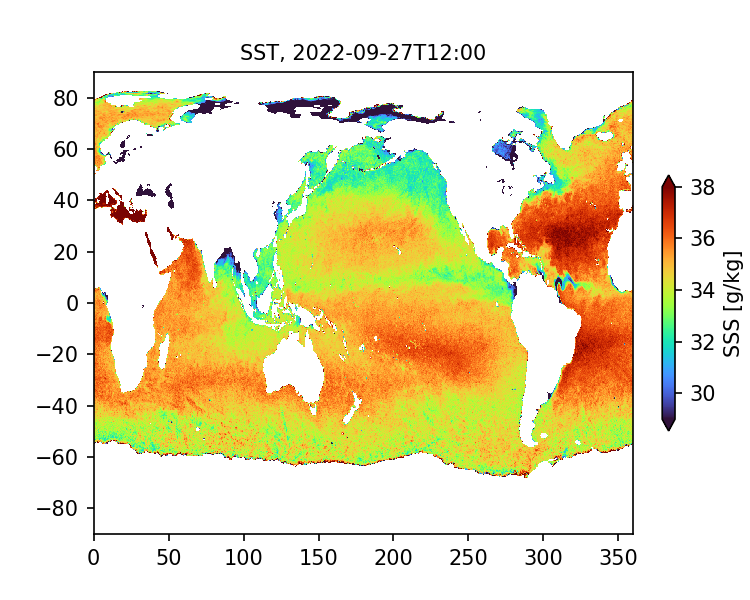

In [37]:
fig = plt.figure()
ax = plt.gca()
plt.set_cmap(cmap=plt.get_cmap('turbo'))
ax.set_title('SST, ' + day_str, size = 10.)
V=np.array([29,38])#np.array([25.5,26.5])+-3.75
cs = plt.pcolormesh(ds2.lon,ds2.lat,ds2.sss_smap_40km.squeeze(),vmin=V[0],vmax=V[1])
#plot_criterion_box(ax,color='k')
cb = plt.colorbar(cs,fraction = 0.022,extend='both')  # adds a colorbar
cb.set_label('SSS [g/kg]',fontsize = 10)  # adds a label to colorbar
